In [1]:
import sys
sys.path.insert(0, '../../src')
from models.NOMINATE import NOMINATE
from utils import visualization as vis
from utils import preprocession as prep
from utils.metrics import compute_metric

import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl

from scipy.spatial import distance
from scipy.optimize import minimize
from tqdm.notebook import tqdm

tqdm.pandas()

## Load Smartvote Data

In [2]:
save_figures = True
target_folder='ecml-paper'

folder_name = 'Smartvote'
data_name = 'Binary'

folder_path = f"../../data/{folder_name}"
data_path = f"../../data/{folder_name}/{data_name}"
output_path = f"../../embeddings/NOMINATE/{folder_name}"

In [3]:
test_users = pd.read_csv(f'{folder_path}/test_candidates.csv', index_col=0)
train_users = pd.read_csv(f'{folder_path}/train_candidates.csv', index_col=0)
train_users

,index,party,color,party_id,yays,nays
0,6,Grüne,#008000,4,48,27
1,17,FDP,#4169E1,2,37,38
2,40,FDP,#4169E1,2,42,33
3,41,Grüne,#008000,4,44,31
4,44,glp,#32CD32,6,44,31
...,...,...,...,...,...,...
1905,4643,Grüne,#008000,4,43,32
1906,4644,Grüne,#008000,4,44,31
1907,4645,SP,#FF0000,1,49,26
1909,4648,CVP,#FFA500,3,48,27


In [4]:
test_reactions = prep.load_all('test_reactions', data_path)
train_reactions = prep.load_all('train_reactions', data_path)
train_reactions.keys()

dict_keys([60, 70, 10, 0, 20, 30, 40, 80, 90, 50])

In [5]:
rollcalls   = prep.load_all('rollcalls', directory=output_path)
legislators = prep.load_all('legislators', directory=output_path)
legislators.keys()

dict_keys([10, 60, 70, 40, 80, 50, 0, 20, 30])

## Check NOMINATE Results

In [6]:
p = 60
legislators[p]

,party,correctYea,wrongYea,wrongNay,correctNay,GMP,CC,coord1D,coord2D,se1D,se2D,corr.1
Legislator 1,Grüne,16,4,4,6,0.574190,0.733333,0.136390,0.068982,0,0,0
Legislator 2,FDP,11,4,3,12,0.591221,0.766667,-0.092352,0.060425,0,0,0
Legislator 3,FDP,17,5,2,6,0.618247,0.766667,-0.056725,-0.139378,0,0,0
Legislator 4,Grüne,14,1,1,14,0.880116,0.933333,0.762421,0.647082,0,0,0
Legislator 5,glp,14,5,3,8,0.557632,0.733333,0.007797,-0.204895,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
Legislator 1618,Grüne,18,2,0,10,0.836458,0.933333,0.476000,0.346116,0,0,0
Legislator 1619,Grüne,17,0,0,13,0.953034,1.000000,0.752324,0.606247,0,0,0
Legislator 1620,SP,16,1,4,9,0.709908,0.833333,0.190066,0.652446,0,0,0
Legislator 1621,CVP,14,1,5,10,0.640644,0.800000,-0.112352,0.427310,0,0,0


In [7]:
rollcalls[p]

,correctYea,wrongYea,wrongNay,correctNay,GMP,PRE,spread1D,spread2D,midpoint1D,midpoint2D,beta,weight1D,weight2D
1,277,123,55,181,0.566376,0.414474,0.156113,-0.068623,0.087241,0.144257,7.752373,1.485213,0.509882
2,104,32,69,436,0.727425,0.416185,0.460828,-0.562721,-0.134233,0.025764,7.752373,1.485213,0.509882
3,67,19,58,524,0.752161,0.384000,0.277523,-0.903286,-0.229092,0.147789,7.752373,1.485213,0.509882
4,373,73,51,146,0.690196,0.433790,-0.868426,0.305845,-0.081751,-0.030030,7.752373,1.485213,0.509882
5,417,80,46,131,0.678632,0.402844,-0.246344,0.724365,-0.130855,0.058010,7.752373,1.485213,0.509882
...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,495,87,25,52,0.673410,0.194245,-0.255618,0.271499,-0.229402,0.029079,7.752373,1.485213,0.509882
72,203,8,42,391,0.794624,0.795918,-0.678570,-0.793830,0.104554,0.074728,7.752373,1.485213,0.509882
73,76,23,51,483,0.749628,0.417323,0.561872,-0.031986,-0.177151,-0.679296,7.752373,1.485213,0.509882
74,347,98,74,140,0.615542,0.277311,-0.258064,-0.164976,-0.082788,-0.099658,7.752373,1.485213,0.509882


In [8]:
nominate = NOMINATE(legislators[p], rollcalls[p], index=train_reactions[p].index)
train_colors = train_users.loc[nominate.train_embedding.index, 'color']
nominate.train_embedding

,x,y
0,0.202569,0.035172
1,-0.137163,0.030810
2,-0.084248,-0.071066
3,1.132357,0.329935
4,0.011580,-0.104472
...,...,...
1905,0.706961,0.176478
1906,1.117361,0.309114
1907,0.282288,0.332670
1909,-0.166867,0.217878


### Accuracy

In [21]:
predictions = pd.DataFrame(nominate.predict(nominate.train_embedding),
                           index = train_reactions[p].index, columns=train_reactions[p].columns)

_ = compute_metric(predictions, train_reactions[0], train_reactions[p].isna())

### Claimed Accuracy
acc_R = (legislators[p].correctYea +legislators[p].correctNay).sum()/legislators[p].iloc[:,1:5].sum().sum()
acc_R

 Fit Accuracy: 0.8436087135224003
 Fit RMSE: 0.3500161355437082
 Imputation Accuracy: 0.8048088779284833
 Imputation RMSE: 0.375147441129991



0.8436087135224003

In [22]:
fit_results = pd.DataFrame(train_reactions[p].progress_apply(nominate.encode, axis=1, result_type='expand').values,
                           index=train_reactions[p].index, 
                           columns=['coord1D', 'coord2D', 'fit'])

fit_predictions = pd.DataFrame(nominate.predict(fit_results.iloc[:,:2]),
                               index = train_reactions[p].index, columns=train_reactions[p].columns)

_ = compute_metric(fit_predictions, train_reactions[0], train_reactions[p].isna())

  0%|          | 0/1622 [00:00<?, ?it/s]

 Fit Accuracy: 0.8336621454993834
 Fit RMSE: 0.3484512199319484
 Imputation Accuracy: 0.7968625839156049
 Imputation RMSE: 0.3785606939617705



## Visualization

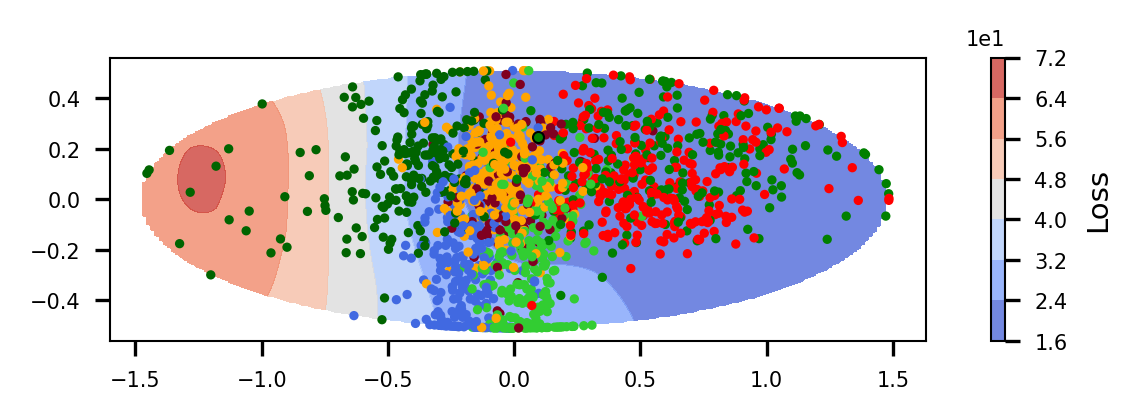

In [22]:
n = 1789
q = 6
fig, ax = plt.subplots(figsize=(vis.textwidth,0.29*vis.textwidth))

vis.plotEmbedding(nominate.train_embedding, n=n, lw=.5, c=train_colors, s=3, ax=ax, highlight={'s':7, 'lw':.5, 'color':train_colors.loc[n]})

if not save_figures:
    ax.set_title(f'Objective Function for User {n} with {p}% Missing Values')

    vis.extendLegend(ax, train_users['party'].unique(), lambda name: prep.partycolors[name], 
                    ncols=1, facecolor='white', loc='center right',bbox_to_anchor=(-0.1, 0.5), )

user = train_reactions[p].loc[n]
answers = user.loc[~user.isna()]
vis.plotObjective(nominate.nan_objective, answers, r=200, ax=ax)
fig.tight_layout()
vis.savefig(fig, save_figures, target=target_folder, name=f'NOMINATE_Objective_{n}')


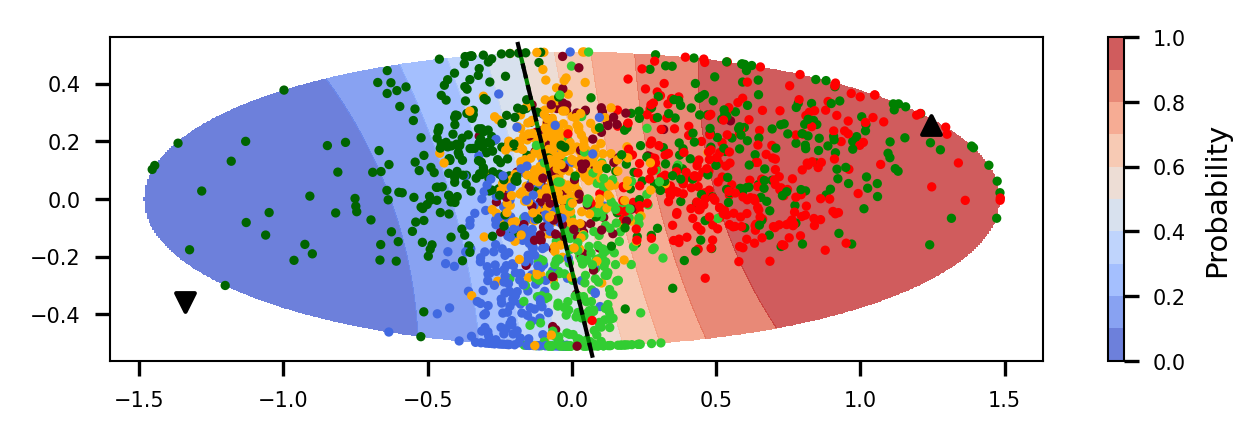

In [9]:
q = 6
fig, ax = plt.subplots(figsize=(vis.textwidth,0.3*vis.textwidth))

vis.plotEmbedding(nominate.train_embedding, lw=.5, c=train_colors, s=3, ax=ax)#, highlight={'s':7, 'lw':.5, 'color':train_colors.loc[n]})

if not save_figures:
    ax.set_title(f'NOMINATE embedding with {p}% Data and Question {q}')

vis.plotFeature(nominate.nan_predict, q, d=0,r=500, ax=ax)
vis.plotQuestion(nominate.items.loc[str(q)], ax=ax)

# vis.extendLegend(ax, train_users['party'].unique(), lambda name: prep.partycolors[name], 
#                   ncols=6, facecolor='white', loc='upper center',bbox_to_anchor=(0.5, -0.1), )
fig.tight_layout()
vis.savefig(fig, save_figures, target=target_folder, name=f'NOMINATE_M{p}_Q{q}')

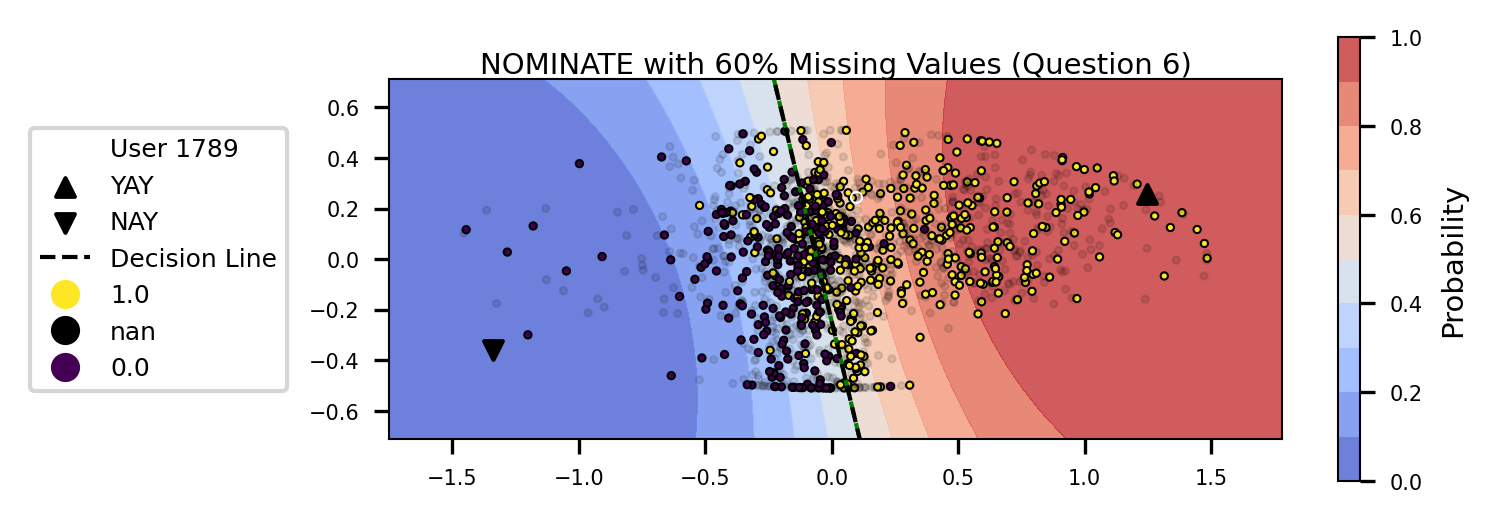

In [21]:
q = 6
fig, ax = plt.subplots(figsize=(vis.textwidth,0.4*vis.textwidth))

ax.set_title(f'NOMINATE with {p}% Missing Values (Question {q})')

answers = train_reactions[p].loc[:,str(q)]
colors = vis.hexColors(answers, vis.colormap)
alphas = [0.1 if c == '#000000' else 1 for c in colors]
# ax = vis.plotEmbedding(nominate.train_embedding, ax=ax, s=3, c=colors, edgecolors='black', alpha=alphas)   
rgba = vis.colormap(user.astype(float).loc[str(q)])
vis.plotEmbedding(nominate.train_embedding, n=n,alpha=alphas, highlight={'edgecolor': 'white', 's':7, 'lw':.5, 'color':rgba},
                      c= vis.hexColors(answers, vis.colormap), edgecolor='black', s=3, lw=0.5, ax=ax)
vis.plotFeature(nominate.predict, q, d=0.15, ax=ax)
vis.plotQuestion(nominate.items.loc[str(q)], ax=ax)

vis.extendLegend(ax, answers.unique(), lambda name: vis.hexColors([name], vis.colormap)[0], ncols=1, 
                 facecolor='white', loc='center right',bbox_to_anchor=(-0.1, .5) )
 
plt.show()

#### Embed new users

In [26]:
test_reactions[p]

,0,1,2,3,4,5,6,7,8,9,...,65,66,67,68,69,70,71,72,73,74
5,NaN,0.0,NaN,NaN,NaN,NaN,1.0,NaN,1.0,1.0,...,1.0,1.0,NaN,NaN,NaN,1.0,NaN,0.0,1.0,0.0
9,1.0,0.0,NaN,NaN,0.0,1.0,1.0,NaN,NaN,NaN,...,1.0,NaN,NaN,1.0,NaN,1.0,NaN,1.0,NaN,NaN
12,NaN,NaN,0.0,1.0,NaN,0.0,NaN,NaN,1.0,1.0,...,NaN,NaN,NaN,0.0,NaN,NaN,0.0,0.0,NaN,NaN
16,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,1.0,NaN,0.0,NaN,NaN,0.0,1.0,1.0,NaN
26,NaN,NaN,0.0,1.0,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,1.0,NaN,NaN,1.0,NaN,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1869,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,1.0,...,NaN,1.0,NaN,0.0,NaN,1.0,NaN,NaN,NaN,0.0
1878,0.0,NaN,0.0,NaN,NaN,0.0,NaN,0.0,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0
1881,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,1.0,NaN,...,0.0,NaN,NaN,NaN,1.0,0.0,0.0,NaN,NaN,NaN
1908,NaN,0.0,NaN,1.0,NaN,0.0,1.0,0.0,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,1.0,NaN,0.0,NaN,NaN


In [27]:
fit_results = pd.DataFrame(test_reactions[p].progress_apply(nominate.encode, axis=1, result_type='expand').values,
                           index=test_reactions[p].index, 
                           columns=['coord1D', 'coord2D', 'fit'])

fit_predictions = nominate.predict(fit_results.iloc[:,:2])

_ = compute_metric(fit_predictions, test_reactions[0], test_reactions[p].isna())

  0%|          | 0/290 [00:00<?, ?it/s]

 Fit Accuracy: 0.8347126436781609
 Fit RMSE: 0.3475814587393982
 Imputation Accuracy: 0.7982375478927203
 Imputation RMSE: 0.3772211900368446



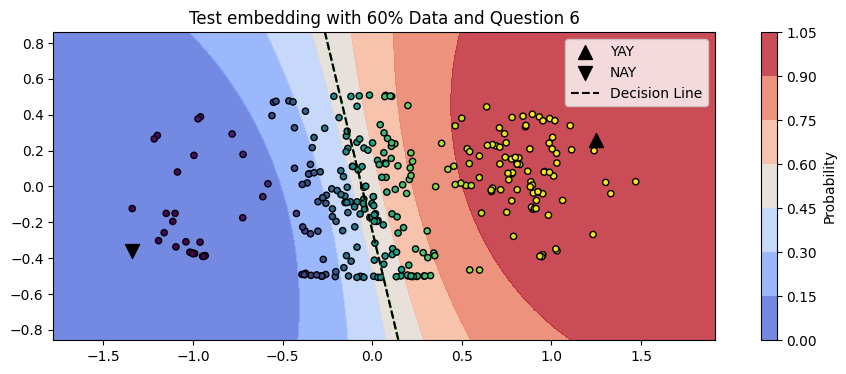

In [28]:
q = 6
fig, ax = plt.subplots(figsize=(12,4))

ax.set_title(f'Test embedding with {p}% Data and Question {q}')

answers = fit_predictions[:,q]
colors = vis.hexColors(answers, vis.colormap)
alphas = [0.1 if c == '#000000' else 1 for c in colors]
ax = vis.plotEmbedding(fit_results, ax=ax, s=20, c=colors, edgecolors='black', alpha=alphas)   
         
vis.plotFeature(nominate.predict, q, d=0.3, ax=ax)
vis.plotQuestion(nominate.items.loc[str(q)], ax=ax)
ax.legend()
plt.show()

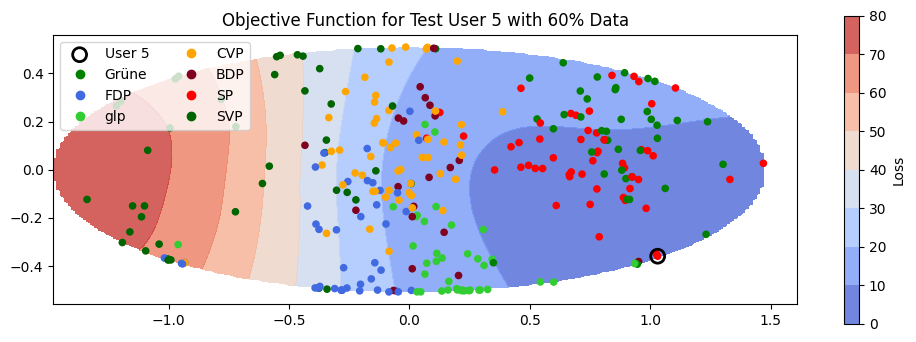

In [29]:
q = 4
n = 5
fig, ax = plt.subplots(figsize=(12,4))

ax = vis.plotEmbedding(fit_results, n=n, ax=ax, s=20, c=test_users['color'])            
ax.set_title(f'Objective Function for Test User {n} with {p}% Data')

vis.extendLegend(ax, train_users['party'].unique(), lambda name: prep.partycolors[name], ncols=2)

user = test_reactions[p].loc[n]
answers = user.loc[~user.isna()]
vis.plotObjective(nominate.nan_objective, answers, r=200, ax=ax)
plt.show()

### Overview of Smartvote Models

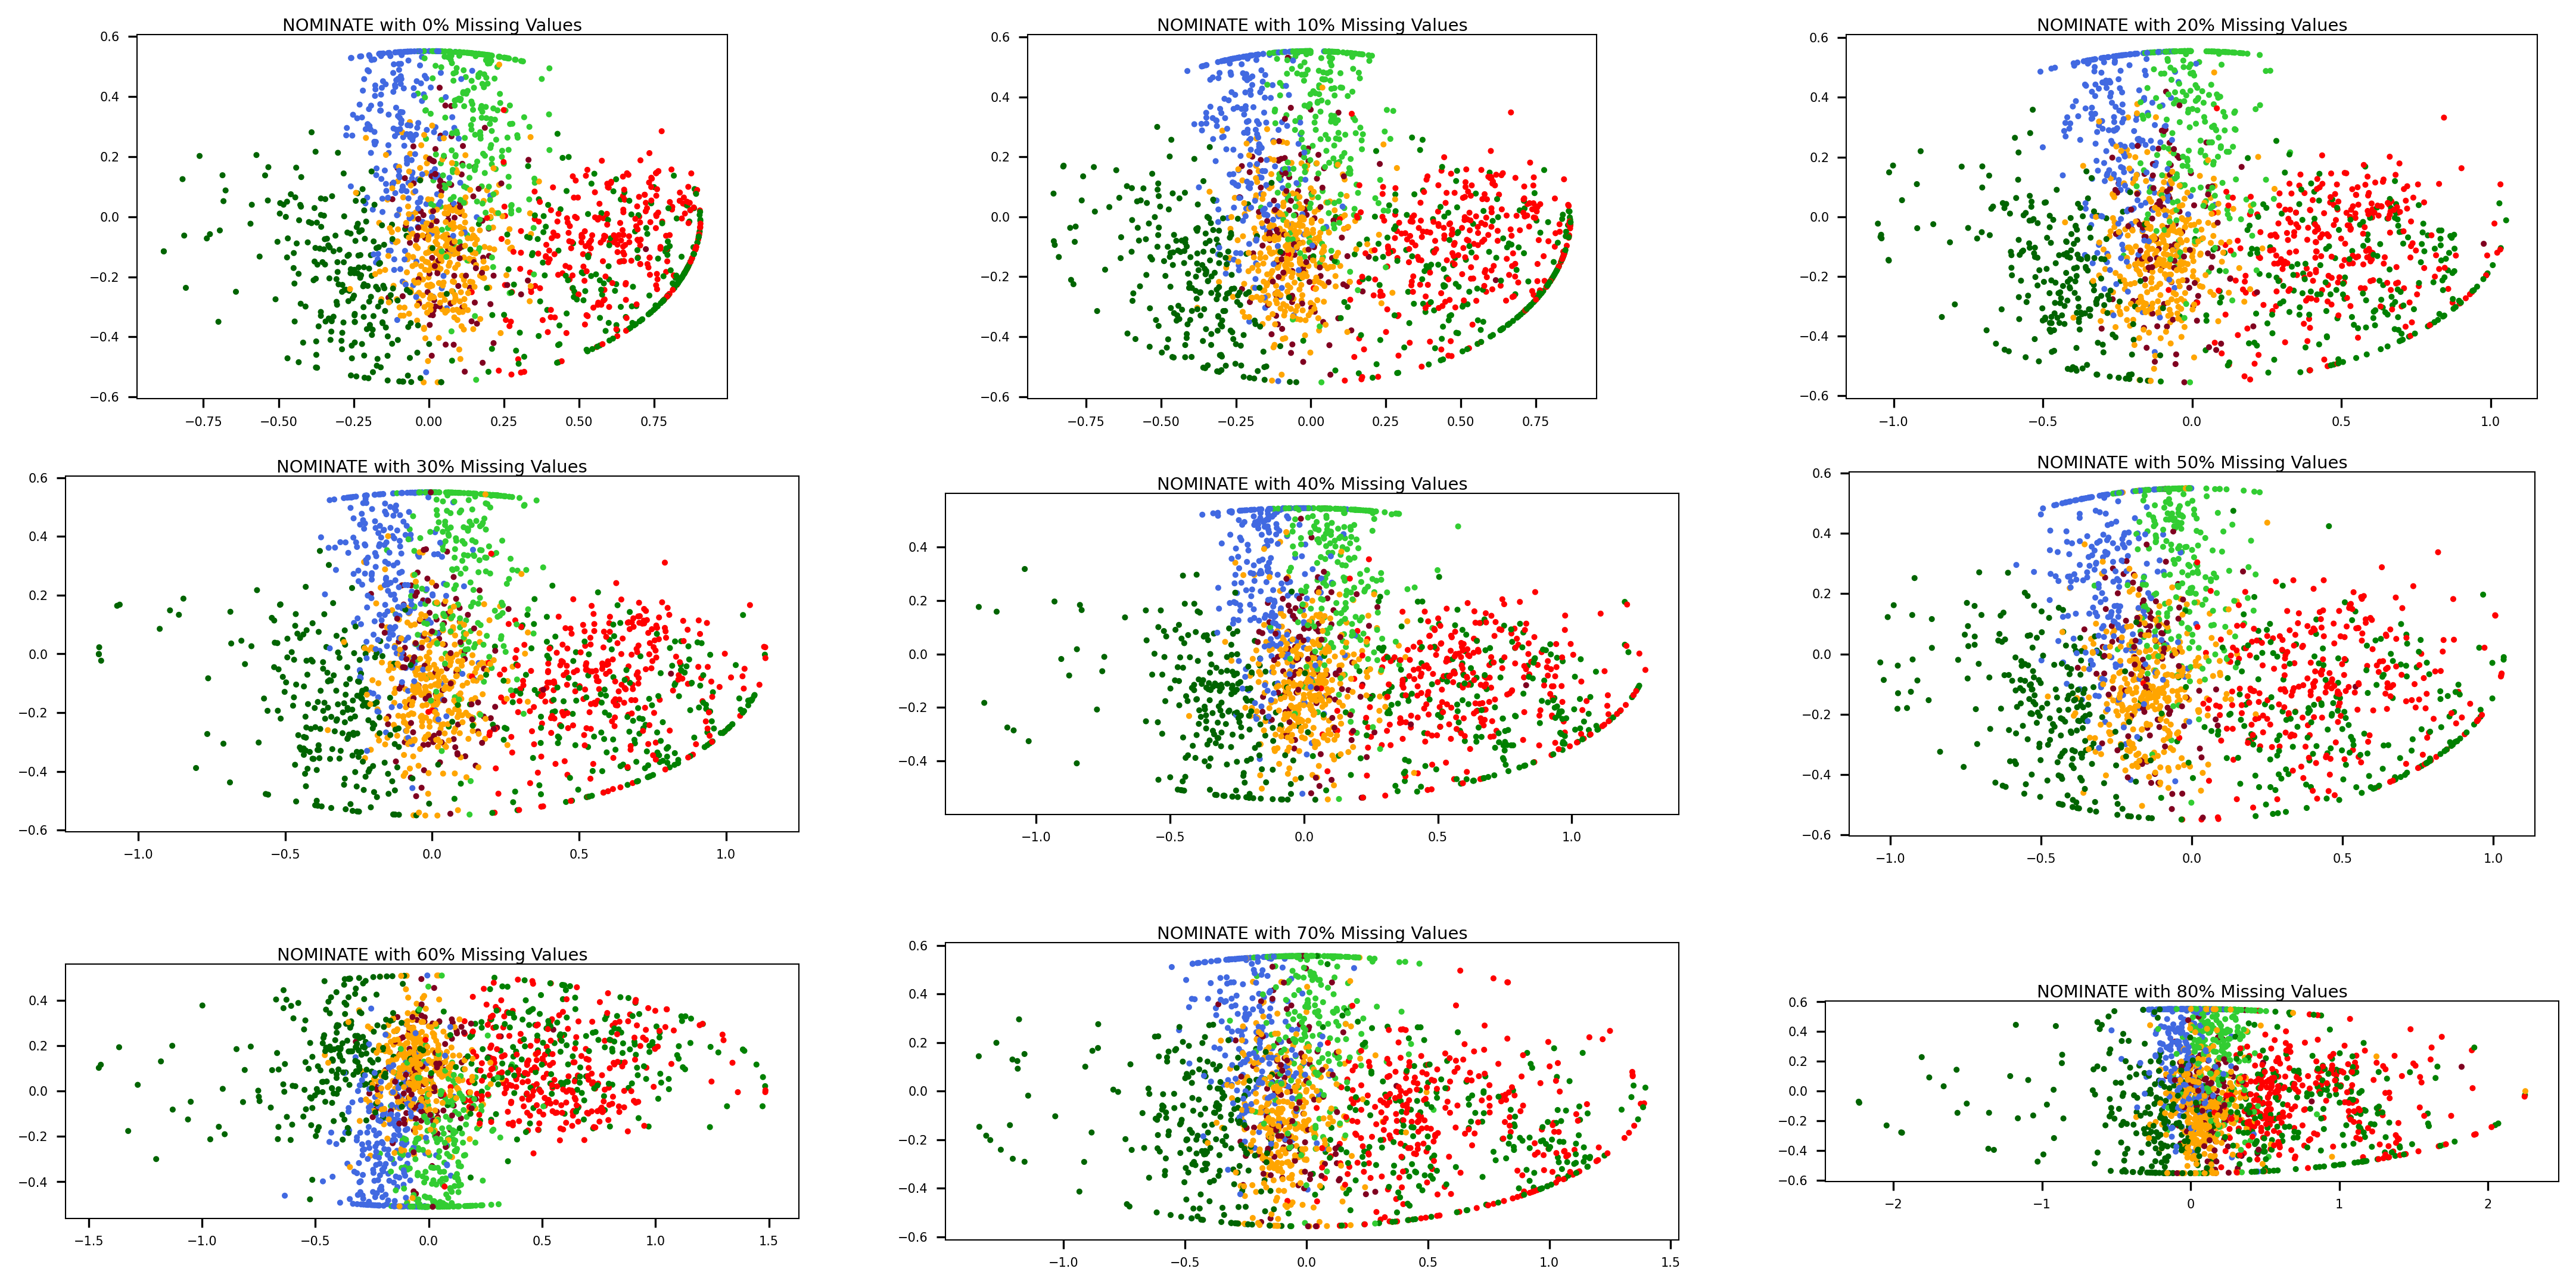

In [53]:
N = len(legislators.keys())
m,n = vis.get_rectangle(N)

# Create figure for subplots
fig, axes = plt.subplots(m, n, figsize=(6*n, 3*m))

for i, p in enumerate(sorted(legislators.keys())):
    nominate = NOMINATE(legislators[p], rollcalls[p], index=train_reactions[p].index)
    ax = vis.plotEmbedding(nominate.train_embedding, ax=axes.flatten()[i], c=train_users['color'], s=2)   
    ax.set_title(f'NOMINATE with {p}% Missing Values')

plt.show()